In [4]:
import gauss_decomp as gdc
import numpy as np
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from matplotlib import colors
from iris_lmsalpy import extract_irisL2data as ei

In [5]:
os.environ['path']= '/Users/souvikb/various_analysis/GaussSep/'
os.environ['results_dir'] = '/Users/souvikb/various_analysis/GaussSep/Results/'

In [6]:
## Testing with a new hinode data

In [7]:
from scipy.io import readsav
b_mag = readsav('bxbybz_29Jul2017_plage.sav')
b_mag.keys()
Bx0_obs = b_mag['bx2']
By0_obs = b_mag['by2']
Bz0_obs = b_mag['bz2']


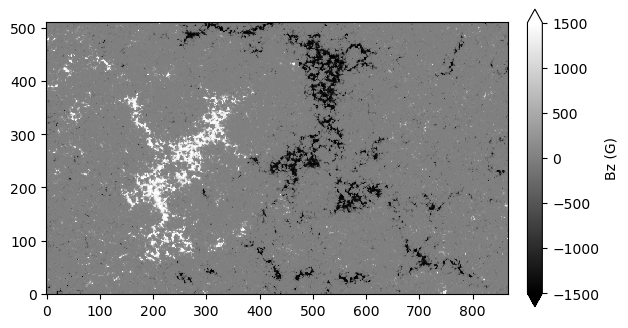

In [8]:
plt.imshow(Bz0_obs, origin='lower', cmap='gray',interpolation='none',vmax=1.5e3,vmin=-1.5e3)
plt.colorbar(label='Bz (G)',extend='both',fraction=0.03, pad=0.04)

304.3904


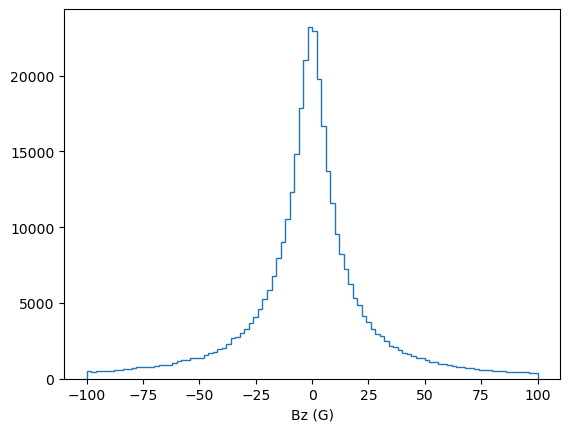

In [9]:
##  Noise level
plt.hist(Bz0_obs.ravel(), bins=100, histtype='step', range=(-100,100))
plt.xlabel('Bz (G)')
print(np.std(Bz0_obs.ravel()))

Fitted Gaussian parameters: amplitude=37876.02025141776, center=-0.5187103172430727, width=12.149003590158893


(-100.0, 100.0)

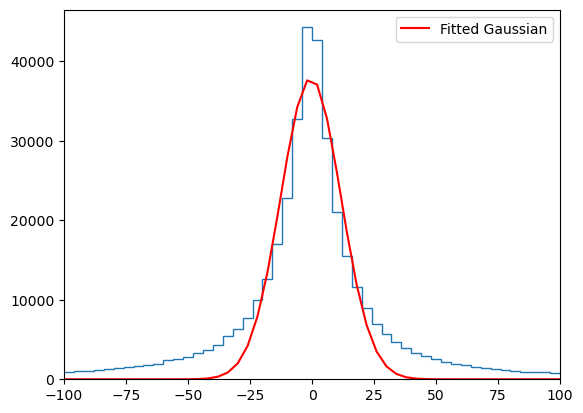

In [10]:
#Fitting a Gaussian to the Bz0_obs to determine the standard deviation of the Gaussian
from scipy.optimize import curve_fit

def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x - cen)**2 / (2 * wid**2))

hist, bin_edges = np.histogram(Bz0_obs.ravel(), bins=100, range=(-200, 200))
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Initial guess for the parameters
initial_guess = [np.max(hist), 0, 10]

# Fit the Gaussian
popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=initial_guess)

# Extract the fitted parameters
amplitude, center, width = popt
print(f"Fitted Gaussian parameters: amplitude={amplitude}, center={center}, width={width}")
plt.hist(Bz0_obs.ravel(), bins=100, histtype='step', range=(-200,200))
plt.plot(bin_centers, gaussian(bin_centers, *popt), color='red', label='Fitted Gaussian')
plt.legend()
plt.xlim([-100, 100])

In [11]:
#------------------------------
# Do PTD, to get toroidal component of horizontal field 
Btx_obs,Bty_obs,Bpx_obs,Bpy_obs,T_obs,dPdz_obs,P_obs,bx_mean_obs,by_mean_obs,bz_mean_obs = \
gdc.ptd_fft_2d( Bx0_obs, By0_obs, Bz0_obs)

In [12]:
#------------------------------
# Do Gauss Sep
Bltx_obs, Blty_obs, Bltz_obs, psilt_obs, \
Bgtx_obs, Bgty_obs, Bgtz_obs, psigt_obs, \
Bx_mean_obs, By_mean_obs, Bz_mean_obs = \
gdc.gauss_sep( Bx0_obs, By0_obs, Bz0_obs)

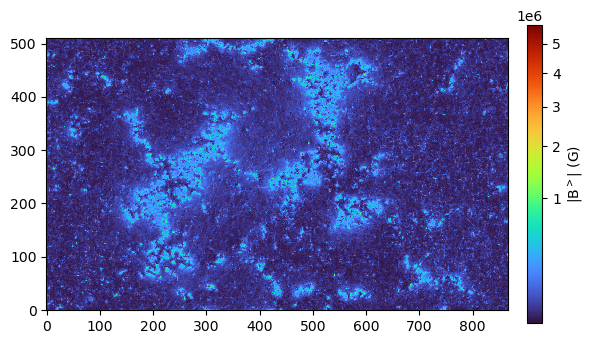

In [13]:
Bgt_net = np.sqrt(Bgtx_obs**2 + Bgty_obs**2 + Bgtz_obs**2)
plt.imshow(Bgt_net**2, origin='lower', cmap='turbo',interpolation='none',norm=colors.PowerNorm(0.5))
plt.colorbar(fraction=0.03, pad=0.04,label=r'|B$^{>}$| (G)')

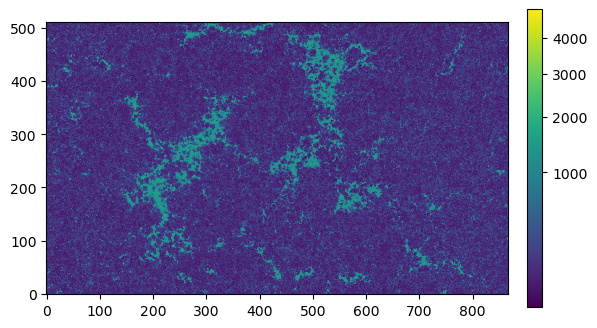

In [14]:
Bt_net = np.sqrt(Btx_obs**2 + Bty_obs**2 + (Bz0_obs - Bz_mean_obs)**2)
plt.imshow(Bt_net, origin='lower', cmap='viridis',interpolation='none',norm=colors.PowerNorm(0.5))
plt.colorbar(fraction=0.03, pad=0.04)

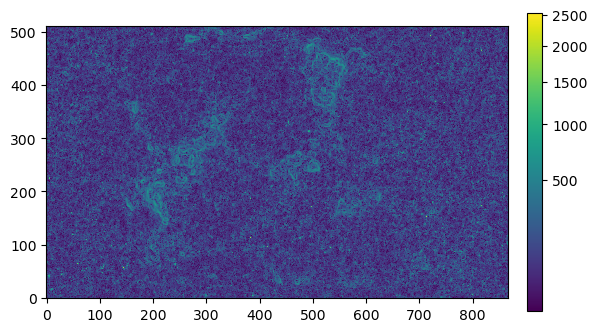

In [15]:
Bp_net = np.sqrt(Bpx_obs**2 + Bpy_obs**2 + (Bz_mean_obs)**2)
plt.imshow(Bp_net, origin='lower', cmap='viridis',interpolation='none',norm=colors.PowerNorm(0.5))
plt.colorbar(fraction=0.03, pad=0.04)

Text(0.5, 1.0, '$\\vec{B}^{>}(x, y, 0)$ due to $\\vec{J}^{>}$')

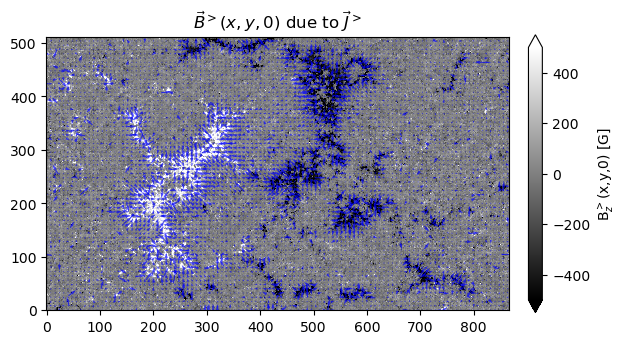

In [16]:
ny, nx = Bgtx_obs.shape
x, y = np.meshgrid(np.arange(nx), np.arange(ny))
plt.imshow(Bgtz_obs, origin='lower', cmap='gray',interpolation='none',vmax=500,vmin=-500)
# plt.contour(Bz0_obs, levels=[1], colors='black')
plt.colorbar(label='B$^{>}_{z}$(x,y,0) [G]', fraction=0.028, pad=0.04,extend='both')
plt.quiver(
    x[::8, ::8], y[::8, ::8],
    Bgtx_obs[::8, ::8], Bgty_obs[::8, ::8],
    scale=2e4, color='blue', pivot='mid',alpha=0.7
)
plt.title(r'$\vec{B}^{>}(x, y, 0)$ due to $\vec{J}^{>}$')

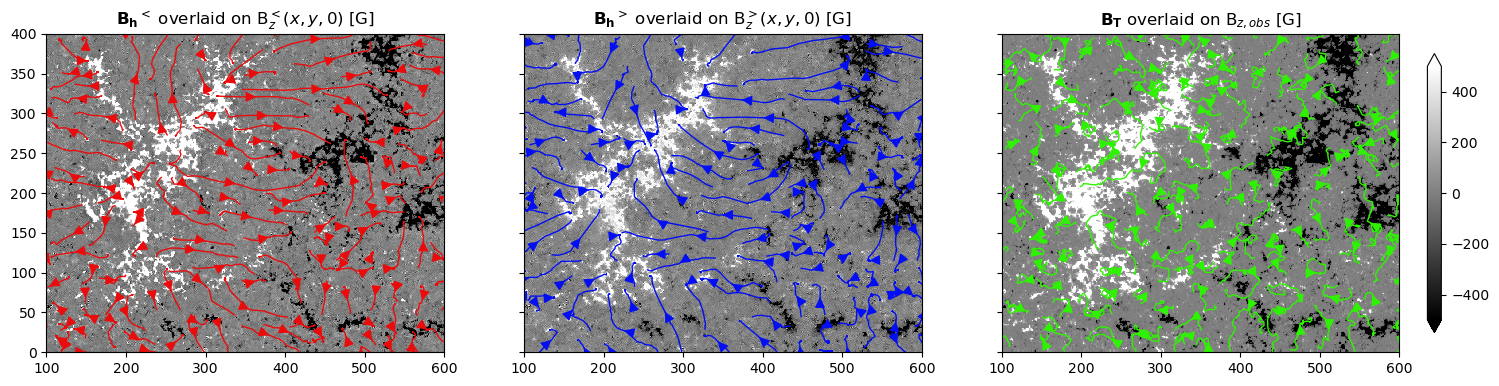

In [132]:
ny, nx = Bgtx_obs.shape
x, y = np.meshgrid(np.arange(nx), np.arange(ny))

fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(18,6),sharex=True,sharey=True)
ax=ax.ravel()
ax[0].imshow(Bltz_obs, origin='lower', cmap='gray',interpolation='none',vmax=500,vmin=-500)
ax[0].set_title(r'$\mathbf{B_h}^{<}$ overlaid on B$^{<}_{z}(x,y,0)$ [G]')
# ax.contour(Bz0_obs, levels=[1], colors='black')
fig.colorbar(ax[0].imshow(Bltz_obs, origin='lower', cmap='gray',interpolation='none',vmax=500,vmin=-500), ax=ax,fraction=0.01, pad=0.02,
             extend='both')
# plt.colorbar(label='B$^{>}_{z}$(x,y,0) [G]', fraction=0.028, pad=0.04,extend='both')
ax[0].streamplot(x, y, Bltx_obs, Blty_obs, color="#EA0C0C", linewidth=1, density=1,arrowsize=1.5)
# ax[0].streamplot(x, y, Bgtx_obs, Bgty_obs, color="#030FF2", linewidth=1, density=1,arrowsize=1.5)
# plt.quiver(
#     x[::10, ::10], y[::10, ::10],
#     Bgtx_obs[::10, ::10], Bgty_obs[::10, ::10],
#     scale=2e4, color='#030FF2', pivot='mid',alpha=0.7
# )
# plt.quiver(
#     x[::10, ::10], y[::10, ::10],
#     Bltx_obs[::10, ::10], Blty_obs[::10, ::10],
#     scale=2e4, color='#FE3D2B', pivot='mid',alpha=0.5
# )
# plt.title(r'$\vec{B}^{>}(x, y, 0)$ due to $\vec{J}^{>}$')

ax[1].imshow(Bgtz_obs, origin='lower', cmap='gray',interpolation='none',vmax=500,vmin=-500) 
ax[1].set_title(r'$\mathbf{B_h}^{>}$ overlaid on B$^{>}_{z}(x,y,0)$ [G]')
# ax[1].streamplot(x, y, Bltx_obs, Blty_obs, color="#EA0C0C", linewidth=1, density=1, arrowsize=1.5)
ax[1].streamplot(x, y, Bgtx_obs, Bgty_obs, color="#030FF2", linewidth=1, density=1, arrowsize=1.5)

ax[2].imshow(Bz0_obs, origin='lower', cmap='gray',interpolation='none',vmax=500,vmin=-500)
ax[2].set_title(r'$\mathbf{B_T}$ overlaid on B$_{z,obs}$ [G]')
ax[2].streamplot(x, y, Btx_obs, Bty_obs, color="#2FF203", linewidth=1, density=1, arrowsize=1.5)
plt.xlim([100, 600])
plt.ylim([0,400])
plt.show()
fig.savefig(os.path.join(os.environ['results_dir'], 'B_and_their_vectors.png'), dpi=300, bbox_inches='tight')


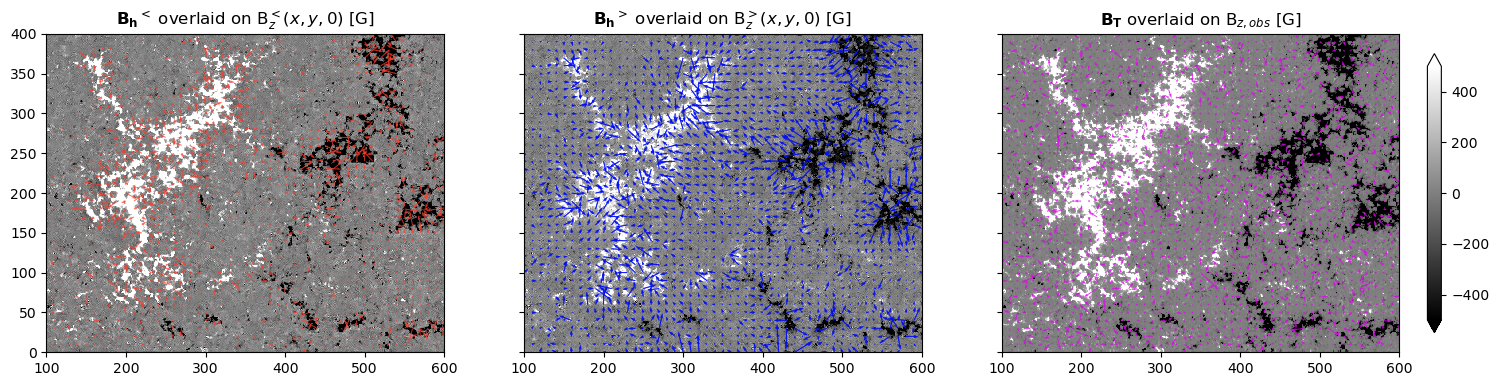

In [18]:
ny, nx = Bgtx_obs.shape
x, y = np.meshgrid(np.arange(nx), np.arange(ny))

fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(18,6),sharex=True,sharey=True)
ax=ax.ravel()
ax[0].imshow(Bltz_obs, origin='lower', cmap='gray',interpolation='none',vmax=500,vmin=-500)
ax[0].set_title(r'$\mathbf{B_h}^{<}$ overlaid on B$^{<}_{z}(x,y,0)$ [G]')
# ax.contour(Bz0_obs, levels=[1], colors='black')
fig.colorbar(ax[0].imshow(Bltz_obs, origin='lower', cmap='gray',interpolation='none',vmax=500,vmin=-500), ax=ax,fraction=0.01, pad=0.02,
             extend='both')
# plt.colorbar(label='B$^{>}_{z}$(x,y,0) [G]', fraction=0.028, pad=0.04,extend='both')
# ax[0].streamplot(x, y, Bltx_obs, Blty_obs, color="#EA0C0C", linewidth=1, density=1,arrowsize=1.5)
# ax[0].streamplot(x, y, Bgtx_obs, Bgty_obs, color="#030FF2", linewidth=1, density=1,arrowsize=1.5)
# plt.quiver(
#     x[::10, ::10], y[::10, ::10],
#     Bgtx_obs[::10, ::10], Bgty_obs[::10, ::10],
#     scale=2e4, color='#030FF2', pivot='mid',alpha=0.7
# )
ax[0].quiver(
    x[::10, ::10], y[::10, ::10],
    Bltx_obs[::10, ::10], Blty_obs[::10, ::10],
    scale=2e4, color='#FE3D2B',alpha=0.8
)
# plt.title(r'$\vec{B}^{>}(x, y, 0)$ due to $\vec{J}^{>}$')

ax[1].imshow(Bgtz_obs, origin='lower', cmap='gray',interpolation='none',vmax=500,vmin=-500) 
ax[1].set_title(r'$\mathbf{B_h}^{>}$ overlaid on B$^{>}_{z}(x,y,0)$ [G]')
# # ax[1].streamplot(x, y, Bltx_obs, Blty_obs, color="#EA0C0C", linewidth=1, density=1, arrowsize=1.5)
# ax[1].streamplot(x, y, Bgtx_obs, Bgty_obs, color="#030FF2", linewidth=1, density=1, arrowsize=1.5)
ax[1].quiver(
    x[::10, ::10], y[::10, ::10],
    Bgtx_obs[::10, ::10], Bgty_obs[::10, ::10],
    scale=1e4, color='#030FF2',alpha=0.8
)
ax[2].imshow(Bz0_obs, origin='lower', cmap='gray',interpolation='none',vmax=500,vmin=-500)
ax[2].set_title(r'$\mathbf{B_T}$ overlaid on B$_{z,obs}$ [G]')
ax[1].quiver(
    x[::10, ::10], y[::10, ::10],
    Bgtx_obs[::10, ::10], Bgty_obs[::10, ::10],
    scale=1e4, color='#030FF2',alpha=0.8
)
ax[2].imshow(Bz0_obs, origin='lower', cmap='gray',interpolation='none',vmax=500,vmin=-500)
ax[2].set_title(r'$\mathbf{B_T}$ overlaid on B$_{z,obs}$ [G]')
ax[2].quiver(
    x[::10, ::10], y[::10, ::10],
    Btx_obs[::10, ::10], Bty_obs[::10, ::10],
    scale=1e4, color="#E203F2",alpha=0.8,minlength=2
)
# ax[2].streamplot(x, y, Btx_obs, Bty_obs, color="#2FF203", linewidth=1, density=1, arrowsize=1.5)
plt.xlim([100, 600])
plt.ylim([0,400])
plt.show()
# fig.savefig(os.path.join(os.environ['results_dir'], 'B_and_their_quiver_vectors.png'), dpi=300, bbox_inches='tight')


Text(0.5, 1.0, 'Magnetic Energy Density due to J$^{>}$')

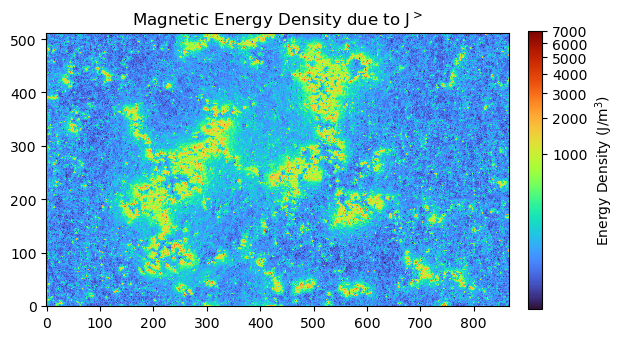

In [19]:
## Calculating the magnetic energy density and not the proxy
Bgtx_SI = Bgtx_obs * 1e-4  # Convert to Tesla
Bgty_SI = Bgty_obs * 1e-4
Bgtz_SI = Bgtz_obs * 1e-4
mu_0 = 1.257e-6 # Permeability of free space in T*m/A
B_energy_density = 0.5 * (Bgtx_SI**2 + Bgty_SI**2 + Bgtz_SI**2) / mu_0
plt.imshow(B_energy_density, origin='lower', cmap='turbo', interpolation='none',norm=colors.PowerNorm(0.3,vmax=7e3))
plt.colorbar(label='Energy Density (J/m$^3$)', fraction=0.028, pad=0.04)
plt.title('Magnetic Energy Density due to J$^{>}$')
# plt.savefig(os.path.join(os.environ['results_dir'], 'B_energy_density.png'), dpi=300, bbox_inches='tight')

## Retrieving IRIS2+ saved atmosphere

In [20]:
from iris_lmsalpy import saveall as sv
aux = sv.load('/Users/souvikb/various_analysis/iris2_p/l2_iris_data/Photospheric_imprints_IRIS_l2_data/inv_mod_IRIS2p_knn_c3_iris_l2_20170729_234952_3620010077_raster_t000_r00000.jbl')
aux.keys()

Loading joblib file... /Users/souvikb/various_analysis/iris2_p/l2_iris_data/Photospheric_imprints_IRIS_l2_data/inv_mod_IRIS2p_knn_c3_iris_l2_20170729_234952_3620010077_raster_t000_r00000.jbl
The varible types are:
data : <class 'numpy.memmap'>
inv : <class 'numpy.memmap'>
model : <class 'list'>
wl : <class 'numpy.memmap'>
wlc : <class 'list'>
wl2size : <class 'list'>
wl2scl : <class 'list'>
extent : <class 'list'>
extent_coords : <class 'tuple'>
mu : <class 'numpy.float64'>
texp : <class 'float'>
obsid : <class 'str'>
percentages : <class 'dict'>
crop_wei4knn : <class 'list'>
chi2 : <class 'numpy.memmap'>
inv_method : <class 'str'>
original_filename : <class 'str'>
name_jbl : <class 'str'>
jbl_file_saving_stamptime : <class 'str'>


Suggested commands:
data = aux['data']
inv = aux['inv']
model = aux['model']
wl = aux['wl']
wlc = aux['wlc']
wl2size = aux['wl2size']
wl2scl = aux['wl2scl']
extent = aux['extent']
extent_coords = aux['extent_coords']
mu = aux['mu']
texp = aux['texp']
obsid 

dict_keys(['data', 'inv', 'model', 'wl', 'wlc', 'wl2size', 'wl2scl', 'extent', 'extent_coords', 'mu', 'texp', 'obsid', 'percentages', 'crop_wei4knn', 'chi2', 'inv_method', 'original_filename', 'name_jbl', 'jbl_file_saving_stamptime'])

In [21]:
model = aux['model']
model[0]['wl'][10:14]

memmap([-5.6, -5.4, -5.2, -5. ])

In [22]:
for m in model: print(m.label_units)


$T\ [kK]$
$vlos\ [km/s]$
$vturb\ [km/s]$
$log10(nne\ [cm^-3])$
$IRL\ [kW\ m^{-2}]$


/var/folders/ms/lnhrcvqs3z1c4t2zkhv2wt600000gp/T/ipykernel_16488/4104632202.py:18: RuntimeWarning: divide by zero encountered in log10
  im = ax[2].imshow(np.log10(np.nanmean(model[3].data[:,:,10:14],axis=2)),interpolation='nearest',vmin=np.log10(np.nanpercentile(model[3].data[:,:,10:14], 10.5)),vmax=np.log10(np.nanpercentile(model[3].data[:,:,10:14], 99)),


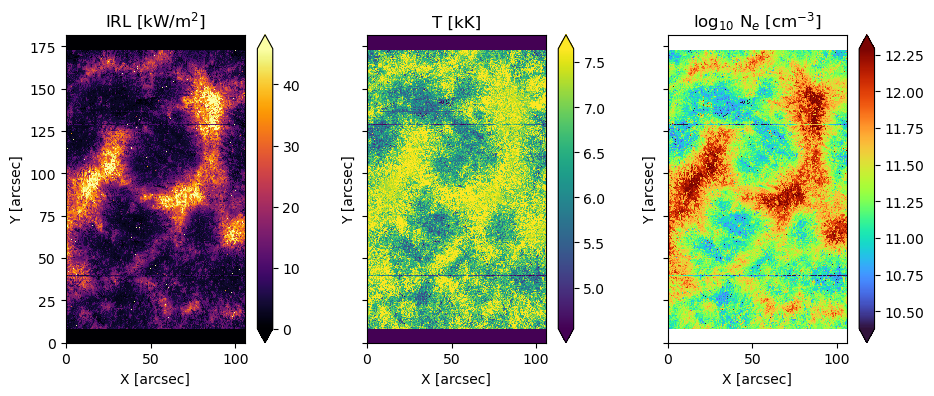

In [24]:
fig, ax = plt.subplots(1,3, figsize=(11,4),sharex=True,sharey=True)
im=ax[0].imshow(model[4].data[:,:,1],interpolation='nearest',vmin=np.nanpercentile(model[4].data[:,:,1], 1),vmax=np.nanpercentile(model[4].data[:,:,1], 99),
           origin='lower',cmap='inferno',extent = [0,320*0.33,0,1095*0.166])
# ax[0].set_title('Bz [G]')
ax[0].set_xlabel('X [arcsec]')
ax[0].set_ylabel('Y [arcsec]')
fig.colorbar(im, ax=ax[0], orientation='vertical',extend='both')
ax[0].set_title('IRL [kW/m$^{2}$]')

im = ax[1].imshow(np.nanmean(model[0].data[:,:,10:14],axis=2),interpolation='nearest',vmin=np.nanpercentile(model[0].data[:,:,10:14], 10),vmax=np.nanpercentile(model[0].data[:,:,10:14], 75),
           origin='lower',cmap='viridis',extent = [0,320*0.33,0,1095*0.166])
# ax[1].set_title('Bz [G]')
ax[1].set_xlabel('X [arcsec]')
ax[1].set_ylabel('Y [arcsec]')
fig.colorbar(im, ax=ax[1], orientation='vertical', extend='both')
ax[1].set_title('T [kK]')

im = ax[2].imshow(np.log10(np.nanmean(model[3].data[:,:,10:14],axis=2)),interpolation='nearest',vmin=np.log10(np.nanpercentile(model[3].data[:,:,10:14], 10.5)),vmax=np.log10(np.nanpercentile(model[3].data[:,:,10:14], 99)),
           origin='lower',cmap='turbo',extent = [0,320*0.33,0,1095*0.166])
# ax[2].set_title('Bz [G]')
ax[2].set_xlabel('X [arcsec]')
ax[2].set_ylabel('Y [arcsec]')
fig.colorbar(im, ax=ax[2], orientation='vertical', extend='both')
ax[2].set_title('log$_{10}$ N$_e$ [cm$^{-3}$]')
fig.savefig(os.path.join(os.environ['results_dir'], 'model_outputs.png'), dpi=300, bbox_inches='tight')